# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import json
import os
# from sodapy import Socrata

# Datetime
import datetime as datetime

import snowflake.connector
# Date
import datetime as dt
import time
from datetime import timedelta

#Math
from math import exp

In [2]:
# # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )
# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

## Acuity

In [8]:
silver = pd.read_csv('SILVER_FACT.ACUITY_ND_CONSULT_EVENTS.csv')
silver.head()

,EVENT_TS,EVENT_TS_UTC,ANONYMOUS_ID,EVENT,APPOINTMENT_BODY_CALENDAR,APPOINTMENT_BODY_FIRST_NAME,APPOINTMENT_BODY_DATETIME_CREATED,APPOINTMENT_BODY_CALENDAR_ID,APPOINTMENT_BODY_CALENDAR_TIMEZONE,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_BODY_TIMEZONE,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_LAST_NAME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_ID,APPOINTMENT_TYPE_ID,APPOINTMENT_BODY_CANCELED,APPOINTMENT_BODY_NO_SHOW
0,2020-10-25 08:37:35.955,2020-10-25 15:37:35.955,464303198,appointment_scheduled,"Dr. Anya Arthen, ND",Ginger,2020-10-25 10:37:32.000,3513713.0,America/New_York,ginger.deshotels@icloud.com,"November 4, 2020",20.0,America/Chicago,2020-11-04 12:50:00.000,Deshotels,Hair Consultation,464303198.0,12799707.0,False,NaN
1,2020-10-06 16:33:10.415,2020-10-06 23:33:10.415,454504090,appointment_scheduled,"Dr. Ariana Zastrow, ND",Vivian,2020-10-06 18:33:07.000,3684820.0,America/New_York,vburgess53@icloud.com,"October 8, 2020",15.0,America/New_York,2020-10-08 17:30:00.000,Burgess,Follow Up Consultation,454504090.0,16040988.0,False,NaN
2,2020-12-12 06:29:43.878,2020-12-12 14:29:43.878,489836193,appointment_scheduled,"Dr. Katelyn Cloyd, ND",Giovanni,2020-12-12 08:29:41.000,3508236.0,America/New_York,ruciglione@gmail.com,"January 7, 2021",20.0,America/New_York,2021-01-07 17:05:00.000,Turi,Hair Consultation,489836193.0,12799707.0,False,NaN
3,2020-12-05 17:46:52.374,2020-12-06 01:46:52.374,486300624,appointment_scheduled,"Dr. Katelyn Cloyd, ND",Nancy,2020-12-05 19:46:49.000,3508236.0,America/New_York,njoymann50@aol.com,"December 22, 2020",20.0,America/New_York,2020-12-22 13:00:00.000,Mann,Hair Consultation,486300624.0,12799707.0,False,NaN
4,2021-01-06 01:34:32.789,2021-01-06 09:34:32.789,502063803,appointment_scheduled,"Dr. Anya Arthen, ND",kendra,2021-01-06 03:34:29.000,3513713.0,America/New_York,kendralinde@gmail.com,"January 22, 2021",20.0,America/New_York,2021-01-22 13:15:00.000,Linde,Hair Consultation,502063803.0,12047150.0,False,NaN


In [10]:
# Create a copy of the DB
silver_acuity = silver.copy()
silver_acuity.shape

(19861, 20)

In [11]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])
# silver_acuity.columns

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

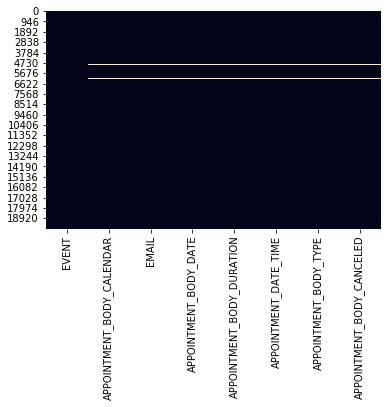

In [12]:
# Check for null values
sns.heatmap(silver_acuity.isnull(), cbar=False)

In [13]:
silver_acuity['EVENT'].value_counts()

appointment_changed        14845
appointment_scheduled       4119
appointment_rescheduled      551
appointment_canceled         346
Name: EVENT, dtype: int64

In [14]:
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      16420
Hair Mineral Analysis Appointment       2498
Follow Up Consultation                   489
Customer consultation                    133
Case Study                                28
Hair Mineral Analysis - Acquisition       15
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [16]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    4006
Name: EVENT, dtype: int64

In [17]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     3643
False     363
Name: Complete, dtype: int64

In [18]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    3643
Name: Complete, dtype: int64

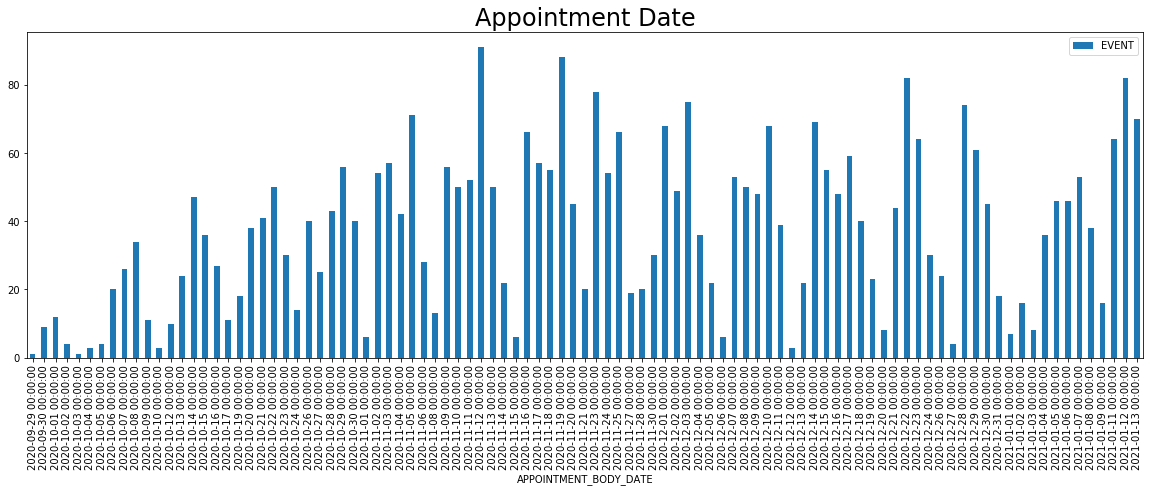

In [20]:
# Group by event, for a visual only 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

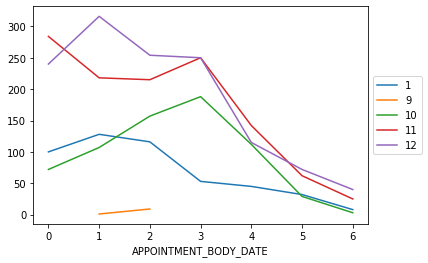

In [21]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.month])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [22]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-09-29 00:00:00')

In [23]:
max(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2021-01-13 00:00:00')

In [24]:
silver_acuity['APPOINTMENT_BODY_DURATION'].value_counts()

20.0    3103
30.0     439
15.0     101
Name: APPOINTMENT_BODY_DURATION, dtype: int64

In [26]:
# silver_acuity.loc[silver_acuity['EMAIL']=='XXXX@yahoo.com']

## SUB

In [28]:
gold_sub = pd.read_csv('GOLD.csv')
# gold_sub.head()

In [33]:
# Create a copy of the dataframe
gold = gold_sub.copy()
gold.columns

# # Drop unneeded columns
# gold.drop(columns=['SUBSCRIPTION_ID', 'CUSTOMER_ID', 'COHORT_PERIOD_KEY',
#        'COHORT_START', 'COHORT_START_PST', 'PERIOD', 'PERIOD_START',
#        'PERIOD_END', 'PERIOD_HAS_ORDER', 'STATUS_CHANGED_AT',
#        'COUNT_BILLED_IN_PERIOD', 'FIRST_COUPON_CODE', 'CUSTOMER_STORE_CREDIT',
#        'FIRST_COUPON_TS', 'FIRST_COUPON_DISCOUNT',
#        'FIRST_COUPON_FINANCE_GROUPING', 'FIRST_COUPON_MARKETING_INITIATIVE',
#        'FIRST_COUPON_MARKETING_INITIATIVE_CHANNEL',
#        'FIRST_COUPON_PURCHASE_TYPE', 'ALL_COUPONS',
#        'PREVIOUS_RETENTION_STATUS', 'CURRENT_RETENTION_STATUS',
#        'RETENTION_STATUS', 'SUBSCRIPTION_RECONCILE_END', 'CREATED_AT',
#        'ORDER_TYPE', 'ITEM_SKU', 'ITEM_GROUP',
#        'TOTAL_ITEMS', 'ITEM_SUB_TYPE', 'ITEM_SKU_TYPE',
#        'ITEM_PRODUCT_CORE_CATEGORY', 'ITEM_PRODUCT_ID', 'ITEM_BILLING_INTERVAL',\
#        'ITEM_SHIPPING_INTERVAL', 'FIRST_MAGENTO_COUPON_DISCOUNT', 'TOTAL_ORDERS', 'TOTAL_ORDER_VALUE'], inplace=True)

Index(['SUBSCRIPTION_ID', 'CUSTOMER_ID', 'EMAIL', 'STATUS', 'ITEM_NAME',
       'ITEM_GENDER', 'TOTAL_ITEMS', 'FIRST_ORDER_AT', 'GROSS_ORDER_VALUE',
       'TOTAL_ORDERS', 'TOTAL_ORDER_VALUE'],
      dtype='object')

In [32]:
# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161570 entries, 0 to 161569
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   SUBSCRIPTION_ID    161570 non-null  int64         
 1   CUSTOMER_ID        161570 non-null  int64         
 2   EMAIL              161570 non-null  object        
 3   STATUS             113040 non-null  object        
 4   ITEM_NAME          161543 non-null  object        
 5   ITEM_GENDER        161543 non-null  object        
 6   TOTAL_ITEMS        161543 non-null  float64       
 7   FIRST_ORDER_AT     161570 non-null  datetime64[ns]
 8   GROSS_ORDER_VALUE  161543 non-null  float64       
 9   TOTAL_ORDERS       161517 non-null  float64       
 10  TOTAL_ORDER_VALUE  161517 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 13.6+ MB


In [34]:
min(gold['FIRST_ORDER_AT'])

'2020-08-01 00:09:46.000'

In [35]:
max(gold['FIRST_ORDER_AT'])

'2021-01-13 00:11:14.000'

In [39]:
gold.head()

,SUBSCRIPTION_ID,CUSTOMER_ID,EMAIL,STATUS,ITEM_NAME,ITEM_GENDER,TOTAL_ITEMS,FIRST_ORDER_AT,GROSS_ORDER_VALUE,TOTAL_ORDERS,TOTAL_ORDER_VALUE
0,631396,455068,nangaj@gmail.com,started,Nutrafol for Women,Women,1.0,2020-09-25 19:54:53.000,79.0,4.0,296.0
1,540514,420891,lfveldhuisx4@yahoo.com,active,Nutrafol for Women's Balance + Stress Adaptogen,Women,1.0,2020-08-15 07:55:01.000,89.0,8.0,593.0
2,540514,420891,lfveldhuisx4@yahoo.com,billed,Nutrafol for Women's Balance + Stress Adaptogen,Women,1.0,2020-08-15 07:55:01.000,89.0,8.0,593.0
3,540514,420891,lfveldhuisx4@yahoo.com,billed,Nutrafol for Women's Balance + Stress Adaptogen,Women,1.0,2020-08-15 07:55:01.000,89.0,8.0,593.0
4,540514,420891,lfveldhuisx4@yahoo.com,NaN,Nutrafol for Women's Balance + Stress Adaptogen,Women,1.0,2020-08-15 07:55:01.000,89.0,8.0,593.0


In [40]:
# AGG
df = gold.iloc[gold.groupby('EMAIL')['FIRST_ORDER_AT'].idxmin()]
df.shape

ValueError: invalid literal for int() with base 10: '0127351@gmail.com'

In [109]:
min(df['FIRST_ORDER_AT'])

Timestamp('2020-09-28 00:43:09')

## Merge

In [110]:
sub1 = pd.merge(silver_acuity,df,how='left',on='EMAIL')

In [111]:
# Create a copy of the dataframe
sub = sub1.copy()

sub = sub[[ 'EMAIL','APPOINTMENT_BODY_DATE', 'FIRST_ORDER_AT', 'LAST_QUIZ_TS',\
           'ITEM_NAME', 'ITEM_GENDER', 'GROSS_ORDER_VALUE']]
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3459 entries, 0 to 3458
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   EMAIL                  3459 non-null   object        
 1   APPOINTMENT_BODY_DATE  3459 non-null   datetime64[ns]
 2   FIRST_ORDER_AT         1220 non-null   datetime64[ns]
 3   LAST_QUIZ_TS           695 non-null    datetime64[ns]
 4   ITEM_NAME              1218 non-null   object        
 5   ITEM_GENDER            1218 non-null   object        
 6   GROSS_ORDER_VALUE      1218 non-null   float64       
dtypes: datetime64[ns](3), float64(1), object(3)
memory usage: 216.2+ KB


In [113]:
max(sub['FIRST_ORDER_AT'])

NaT

In [93]:
#Round to the day
# sub['APPOINTMENT_BODY_DATE'] = sub['APPOINTMENT_BODY_DATE'].dt.round('D')
# sub['FIRST_ORDER_AT'] = sub['FIRST_ORDER_AT'].dt.round('D')
# sub['LAST_QUIZ_TS'] = sub['LAST_QUIZ_TS'].dt.round('D')

# # create start year column to be able to make years_working column
# df['start_year'] = df['Agency Start Date'].apply(lambda x: int(x[6:]))
# df['years_with_city'] = df[['Fiscal Year']].sub(df['start_year'], axis=0)

# sub.loc[sub['FIRST_ORDER_AT']=='NaT', 'FIRST_ORDER_AT']= np.nan 
# sub.dropna(inplace = True)
# sub.info()

In [114]:
sub['TimeDifference'] = \
(((sub['FIRST_ORDER_AT']))-(sub['APPOINTMENT_BODY_DATE']))
sub.head()

,EMAIL,APPOINTMENT_BODY_DATE,FIRST_ORDER_AT,LAST_QUIZ_TS,ITEM_NAME,ITEM_GENDER,GROSS_ORDER_VALUE,TimeDifference
0,hunterelliott510@gmail.com,2020-12-29,NaT,NaT,NaN,NaN,NaN,NaT
1,ashleynizzle@yahoo.com,2021-01-06,2020-12-07 18:53:45,NaT,Nutrafol for Women + Hairbiotic + Stress Adapt...,Women,99.0,-30 days +18:53:45
2,foxbody1986@hotmail.com,2020-12-07,2020-11-30 21:25:18,NaT,Nutrafol for Women's Balance + Hairbiotic + St...,Women,99.0,-7 days +21:25:18
3,anbavitz@gmail.com,2020-12-22,2020-11-19 16:52:59,NaT,Nutrafol for Women's Balance,Women,79.0,-33 days +16:52:59
4,jsw107@georgetown.edu,2020-10-30,NaT,NaT,NaN,NaN,NaN,NaT


In [115]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3459 entries, 0 to 3458
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   EMAIL                  3459 non-null   object         
 1   APPOINTMENT_BODY_DATE  3459 non-null   datetime64[ns] 
 2   FIRST_ORDER_AT         1220 non-null   datetime64[ns] 
 3   LAST_QUIZ_TS           695 non-null    datetime64[ns] 
 4   ITEM_NAME              1218 non-null   object         
 5   ITEM_GENDER            1218 non-null   object         
 6   GROSS_ORDER_VALUE      1218 non-null   float64        
 7   TimeDifference         1220 non-null   timedelta64[ns]
dtypes: datetime64[ns](3), float64(1), object(3), timedelta64[ns](1)
memory usage: 243.2+ KB


In [31]:
stop

NameError: name 'stop' is not defined

In [ ]:
# # Group by email 
# chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'time difference':'count'})
# chart.isna().sum()

In [117]:
# Export data
sub.to_csv('sub.csv')